# Image Classification

*Brain Tumor Detection via Binary Classification of Magnetic Resonance Imaging (MRI) Scans*

![mri](../images/mri.png)

In [2]:
import aiqc
from aiqc import datum

---

## Load Data

* Features from a folder of images.
* Labels from a spreadsheet of medical status.

In [4]:
img_splitset = aiqc.Pipeline.Image.make(
    
    # Features: images.
    folderPath_or_urls = '/Users/layne/Desktop/MRI_scans'
    
    # Labels: tabular.
    , tabularDF_or_path = datum.to_pandas('brain_tumor.csv')
    , tabular_dtype = None
    , label_column = 'status'
    , label_encoder = None
    
    # Split.
    , size_test = 0.22
    , size_validation = 0.14
    , fold_count = None
    , bin_count = None
)

🖼️ Ingesting Images 🖼️: 100%|███████████████████████| 80/80 [00:00<00:00, 193.46it/s]


In [5]:
images_pillow = aiqc.Dataset.Image.to_pillow(id=img_splitset.featureset.dataset.id, samples=[6,47])

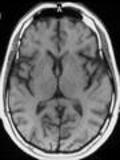

In [6]:
images_pillow[0]

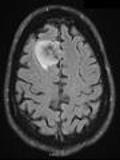

In [7]:
images_pillow[1]

In [8]:
aiqc.Dataset.Tabular.to_pandas(id=img_splitset.label.dataset.id).drop(columns=['url']).sample(10)

,status
55,1
61,1
48,1
0,0
52,1
42,1
44,1
24,0
33,0
56,1


---

## Build Model

In [9]:
import keras
from keras import metrics
from keras.models import Sequential
from keras.callbacks import Callback, History
from keras.layers import Conv1D, Dense, Dropout, Activation, BatchNormalization
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

In [10]:
def fn_build(features_shape, label_shape, **hp):
    model = Sequential()
    
    # Convolutional block.
    for i in range(hp['conv_blocks']):
        if (hp['concave'] == True):
            multiplier = i + 1
        elif (hp['concave'] == False):
            multiplier = hp['conv_blocks'] - i
        
        if (i == 0):
            model.add(Conv1D(hp['conv_neurons']*multiplier, input_shape=features_shape, kernel_size=hyperparameters['kernel_size'], padding='same', kernel_initializer=hp['cnn_init']))
        elif (i > 0):
            model.add(Conv1D(hp['conv_neurons']*multiplier, kernel_size=hp['kernel_size'], padding='same', kernel_initializer=hp['cnn_init']))
        
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=hp['pool_size']))
        model.add(Dropout(0.4))

    model.add(Flatten())
    
    # Dense block.
    for i in range(hp['dense_blocks']): 
        model.add(Dense(hp['dense_neurons']))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.4))
    
    # Output layer.
    model.add(Dense(label_shape[0], activation='sigmoid'))
    return model

In [11]:
def fn_train(model, loser, optimizer, samples_train, samples_evaluate, **hp):   
    model.compile(
        optimizer=optimizer
        , loss=loser
        , metrics=['accuracy']
    )
    
    # Early stopping.
    metric_cuttoffs = [
        {"metric":"val_accuracy", "cutoff":0.90, "above_or_below":"above"},
        {"metric":"accuracy", "cutoff":0.90, "above_or_below":"above"},
        {"metric":"val_loss", "cutoff":1.00, "above_or_below":"below"},
        {"metric":"loss", "cutoff":1.00, "above_or_below":"below"}]
    cutoffs = aiqc.TrainingCallback.Keras.MetricCutoff(metric_cuttoffs)
    
    # Training runs.
    model.fit(
        samples_train["features"]
        , samples_train["labels"]
        , validation_data = (
            samples_evaluate["features"]
            , samples_evaluate["labels"]
        )
        , verbose = 0
        , batch_size = hp['batch_size']
        , callbacks=[History(), cutoffs]
        , epochs = hp['epoch_count']
    )

    return model

---

## Stage Experiment

In [12]:
hyperparameters = {
    "concave": [False]
    
    , "conv_blocks": [4]
    , "conv_neurons": [24]
    , "pool_size": [2]
    , "kernel_size": [3]
    , "batch_size": [8] #8 did best. tried 5 and 6 again, no.
    , "cnn_init": ['normal'] #default is glorot
    
    , "dense_blocks": [1]
    , "dense_neurons": [32] #64 did well.
    
    , "epoch_count": [500]
}

In [13]:
queue = aiqc.Experiment.make(
    
    # Analysis.
    library = "keras"
    , analysis_type = "classification_binary"
    
    # Model.
    , fn_build = fn_build
    , fn_train = fn_train
    , hyperparameters = hyperparameters
    
    # Which Preprocesses.
    , splitset_id = img_splitset.id
    , foldset_id = None
    , encoderset_id = None
    
    # Options
    , repeat_count = 2
    , hide_test = False
)

In [14]:
queue.run_jobs()

🔮 Training Models 🔮:   0%|                                                  | 0/2 [00:00<?, ?it/s]

:: Epoch #238 ::Congratulations - satisfied early stopping thresholds defined in `MetricCutoff` callback:[{'above_or_below': 'above', 'cutoff': 0.9, 'metric': 'val_accuracy'},
 {'above_or_below': 'above', 'cutoff': 0.9, 'metric': 'accuracy'},
 {'above_or_below': 'below', 'cutoff': 1.0, 'metric': 'val_loss'},
 {'above_or_below': 'below', 'cutoff': 1.0, 'metric': 'loss'}]


🔮 Training Models 🔮:  50%|█████████████████████                     | 1/2 [00:39<00:39, 39.73s/it]


Queue was gracefully interrupted.

